<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-with-pytorch-lightning/01-pytorch-lightning-basic/02_cancer_tissue_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Cancer Tissue Detection

In this notebook, we will build a CNN model for the Histopathologic Cancer Detection dataset to identify
metastatic cancer in small image patches taken from larger digital pathology scans.

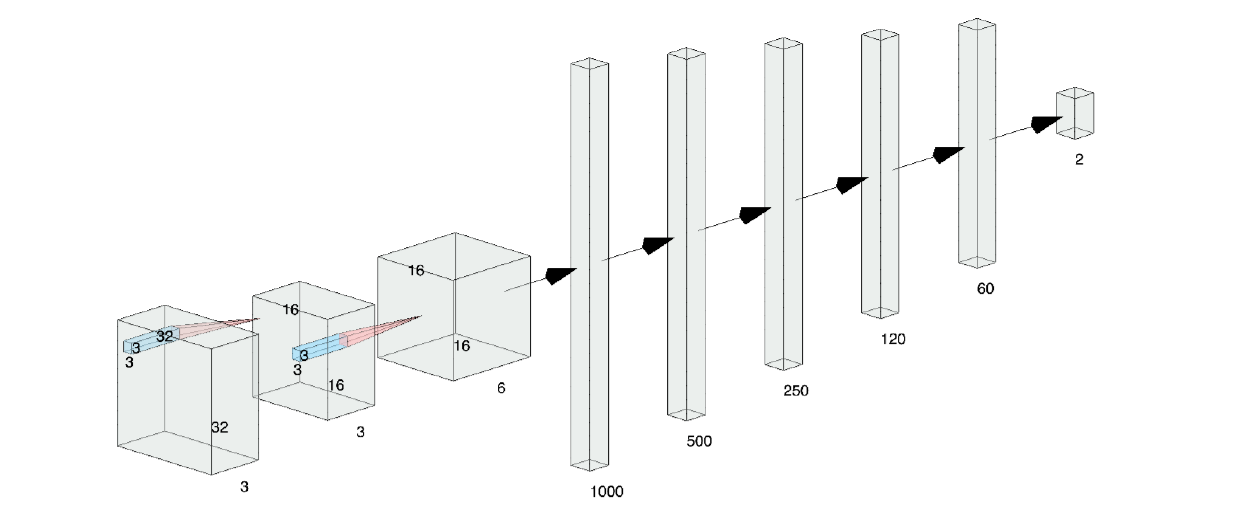

##Setup

In [ ]:
!pip install pytorch-lightning --quiet
!pip install opendatasets --upgrade --quiet

In [2]:
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
import pytorch_lightning as pl

In [3]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

pandas version: 1.3.5
numpy version: 1.21.6
torch version: 1.12.1+cu113
pytorch ligthening version: 1.7.6


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle-keys"

In [6]:
%%shell

# download dataset from kaggle> URL: https://www.kaggle.com/c/histopathologic-cancer-detection
kaggle competitions download -c histopathologic-cancer-detection

unzip -qq histopathologic-cancer-detection.zip
rm -rf histopathologic-cancer-detection.zip

100% 6.30G/6.31G [00:50<00:00, 143MB/s]
100% 6.31G/6.31G [00:50<00:00, 134MB/s]


##Dataset

Let's read the dataset and see the head of the dataframe in pandas.

In [7]:
cancer_labels = pd.read_csv("train_labels.csv")
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
cancer_labels["label"].value_counts()

0    130908
1     89117
Name: label, dtype: int64

There are 130908 normal cases (0) and and 89117 abnormal (cancerous) cases (1)

So, it is not highly unbalanced.

In [9]:
print(f"No. of images in training dataset: {len(os.listdir('train'))}")
print(f"No. of images in testing dataset: {len(os.listdir('test'))}")

No. of images in training dataset: 220025
No. of images in testing dataset: 57458


This is a huge dataset, which requires a lot of compute time and resources so for the purpose of learning our first basic image classification model.

We will downsample it to 5000 images and then split it into training and testing dataset.

In [10]:
np.random.seed(0)

train_imgs_orig = os.listdir("train")

selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
  selected_image_list.append(img)
print(len(selected_image_list))
print(selected_image_list[0])

10000
1414633fc8202d424b64a91110a3a05e30aba545.tif


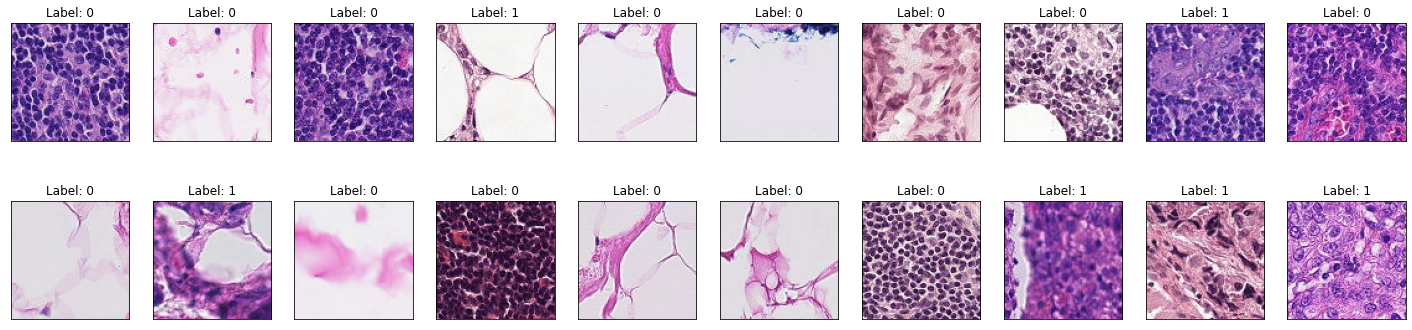

In [11]:
# let's plot some images.
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
  ax = fig.add_subplot(2, 20 // 2, idx + 1, xticks=[], yticks=[])
  im = Image.open("train/" + img)
  plt.imshow(im)
  label = cancer_labels.loc[cancer_labels["id"] == img.split(".")[0], "label"].values[0]
  ax.set_title(f"Label: {label}")

In [12]:
# let's split the data into train and test data
np.random.seed(0)

np.random.shuffle(selected_image_list)

cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:]
print(f"Number of images in the downsampled training dataset: {len(cancer_train_idx)}")
print(f"Number of images in the downsampled testing dataset: {len(cancer_test_idx)}")

Number of images in the downsampled training dataset: 8000
Number of images in the downsampled testing dataset: 2000


###Preprocessing the dataset

In [13]:
# Extracting the labels for the images that were selected in the downsampled data
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
  label_tuple = cancer_labels.loc[cancer_labels["id"] == img.split(".")[0]]
  id_list.append(label_tuple["id"].values[0])
  label_list.append(label_tuple["label"].values[0])

selected_image_labels["id"] = id_list
selected_image_labels["label"] = label_list
selected_image_labels.head()

,id,label
0,aba8c9240cb60ef81d2db18d3631611e03163bf1,0
1,c32e5664072498e23a441b614f71c0a0428ed727,0
2,c5e2d6be658f80396e54c502b68342c66f9d4386,0
3,4165364d9278718f5bbd85c807b506a984355767,1
4,2990ee3654ef39f08f8c7e1f7f274c21857ab221,1


In [18]:
# dictionary with labels and ids of train data
img_label_dict = {k: v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

###Preparing the dataset

The data preparation process will itself consist of multiple steps, as follows:

* Loading the dataset
* Augmenting the dataset

Pytorch lightning expects data to be in folders with the classes. We cannot use the DataLoader module directly when all train images are in one folder without subfolders. 

So, we will write our custom function to carry out the loading.

In [14]:
class CancerDataset(Dataset):
  def __init__(self, data_folder, transform=T.Compose([T.CenterCrop(32), T.ToTensor()]), dict_labels={}):
    self.data_folder = data_folder
    self.list_image_files = [s for s in os.listdir(data_folder)]
    self.transform = transform
    self.dict_labels = dict_labels
    self.labels = [dict_labels[i.split(".")[0]] for i in self.list_image_files]

  def __len__(self):
    return len(self.list_image_files)

  def __getitem__(self, idx):
    img_name = os.path.join(self.data_folder, self.list_image_files[idx])
    image = Image.open(img_name)
    image = self.transform(image)
    img_name_short = self.list_image_files[idx].split(".")[0]

    label = self.dict_labels[img_name_short]
    return image, label

Now, we will start the data preprocessing by
augmenting the images.

In [16]:
train_data_transformer = T.Compose([
  T.CenterCrop(32), 
  T.RandomHorizontalFlip(),
  T.RandomVerticalFlip(),
  T.ToTensor()
])

test_data_transformer = T.Compose([
  T.CenterCrop(32), 
  T.ToTensor()
])

Now, we will call our `CancerDataset` custom class with the path to the data
folder, transformer, and the image label dictionary.

In [20]:
%%time

# Load train data
training_set = CancerDataset(data_folder="train", transform=train_data_transformer, dict_labels=img_label_dict)

KeyError: ignored

In [ ]:
%%time

# Load test data
testing_set = CancerDataset(data_folder="train/", transform=train_data_transformer, dict_labels=img_label_dict)